# Анализ гипотез по увеличению выручки интернет-магазина<br>

**Задача:** приоретизировать гипотезы по увеличению выручки интернет-магазина, проанализировать результаты А/В-теста.<br>

На первом этапе исследования выполняется приоретизация гипотез на базе соответствующего датасета, в который входят:<br>
  * Hypothesis — краткое описание гипотезы<br>
  * Reach — охват пользователей по 10-балльной шкале<br>
  * Impact — влияние на пользователей по 10-балльной шкале<br>
  * Confidence — уверенность в гипотезе по 10-балльной шкале<br>
  * Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы<br>

На втором этапе проводится анализ результатов А/В-теста. Для него используются два датасета:<br>

с данными о заказах:<br>
  * transactionId — идентификатор заказа<br>
  * visitorId — идентификатор пользователя, совершившего заказ<br>
  * date — дата, когда был совершен заказ<br>
  * revenue — выручка заказа<br>
  * group — группа A/B-теста, в которую попал заказ<br>

с данными о посетителях:<br>
  * date — дата<br>
  * group — группа A/B-теста<br>
  * visitors — количество пользователей в указанную дату в указанной группе A/B-теста

План работы:<br>
1. [Загрузка данных](#start)<br>
2. [Предобработка данных](#preprocessing)<br>
3. [Приоритизация гипотез](#prioritization)<br>
4. [Анализ результатов А/В-теста](#analysis)<br>
5. [Выводы](#summary)

In [1]:
# загрузим необходимые для работы библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import warnings

In [2]:
# скроем предупреждения
warnings.filterwarnings('ignore')
# настроим вывод чисел без научной нотации 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# настроим вывод значений в ячейках без сокращений
pd.set_option("display.max_colwidth", None)

#### 1. <a id="start">Загрузка данных</a>
<br>
Откроем файлы с данными и изучим общую информацию.

In [3]:
# укажем путь к датасетам
path = r'C:\Users\Valentina\pr\pr_env\projects\decision making in business\\'
# откроем датасеты
hypotheses = pd.read_csv(path + 'hypothesis.csv')
orders = pd.read_csv(path + 'orders.csv')
visitors = pd.read_csv(path + 'visitors.csv')
    
#выведем первые строки и общую информацию
display(hypotheses.head())
print(hypotheses.info())
display(orders.head())
print(orders.info())
display(visitors.head())
visitors.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


На первый взгляд особых проблем в данных нет. Необходимо изменить тип данных для столбцов с датами и проверить датафреймы на наличие других проблем.

#### 2. <a id="preprocessing">Предобработка данных</a>
<br>
Изменим тип данных в столбцах с датами.

In [4]:
# переведем столбцы с датами в формат даты
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
print(orders.info())
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Для удобства приведем названия столбцов к змеиному регистру.

In [5]:
# переименуем столбцы
hypotheses.columns = hypotheses.columns.str.lower()
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

Проверим, совпадают ли временные периоды в двух датафреймах.

In [6]:
# выведем самые ранние и поздние даты
print('Временные рамки заказов:', orders['date'].min(), orders['date'].max())
print('Временные рамки посещений:', visitors['date'].min(), visitors['date'].max())

Временные рамки заказов: 2019-08-01 00:00:00 2019-08-31 00:00:00
Временные рамки посещений: 2019-08-01 00:00:00 2019-08-31 00:00:00


В обоих датасетах представлены данные за август 2019 года. Судя по общей информации, пропусков в датафреймах нет. Для точности проверим еще раз.

In [7]:
#выведем количество пропусков по столбцам
print(hypotheses.isna().sum())
print(orders.isna().sum())
visitors.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64
transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


date        0
group       0
visitors    0
dtype: int64

Пропуски отсутствуют.<br>
Поищем дубликаты в данных. 

In [8]:
# выведем количество явных дубликатов
print(hypotheses.duplicated().sum())
print(orders.duplicated().sum())
visitors.duplicated().sum()

0
0


0

Дубликатов в данных нет. Но нужно проверить, не попали ли какие-то посетители в обе группы.

In [9]:
# найдем уникальных посетителей для обеих групп и сохраним их в отдельных множествах
visitors_A = set(orders[orders['group'] == 'A']['visitor_id'].unique())
visitors_B = set(orders[orders['group'] == 'B']['visitor_id'].unique())
# найдем пересечение множеств
both_groups_visitors = visitors_A.intersection(visitors_B)
# выведем количество посетителей, попавших в обе группы
len(both_groups_visitors)

58

58 посетителей - около 5% от общего числа. Их присутствие в обеих группах исказит результаты теста, поэтому придется от них избавиться.

In [10]:
# уберем из датафрейма с заказами записи о посетителях, попавших в обе группы
orders = (
    orders[np.logical_not(orders['visitor_id'].isin(both_groups_visitors))]
    .reset_index(drop=True)
)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 39.8+ KB


Необходимо отметить, что присутствие одних и тех же пользователей в обеих группах теста указывает на ошибку в сборе данных. В нашем случае удаление этих пользователей повлияет на конверсию, поскольку мы можем удалить этих пользователей из таблицы с заказами, но не сможем удалить из таблицы с визитами, так как там данные уже агрегированы за день. Проверить корректность распределения пользователей следовало бы сразу после запуска теста, чтобы вовремя принять меры, однако в данном случае мы имеем дело уже с результатами. Таким образом, удаление части пользователей является вынужденным, но не оптимальным решением.

Посмотрим, есть ли в данных выбросы и аномалии. Нас интересуют выручка от заказа, количество заказов на одного посетителя и количество посетителей за день.

Сначала изучим выручку.

count      1016.00
mean       8300.81
std       42121.99
min          50.00
25%        1190.00
50%        2955.00
75%        8134.25
90%       17990.00
95%       26785.00
99%       53904.00
max     1294500.00
Name: revenue, dtype: float64


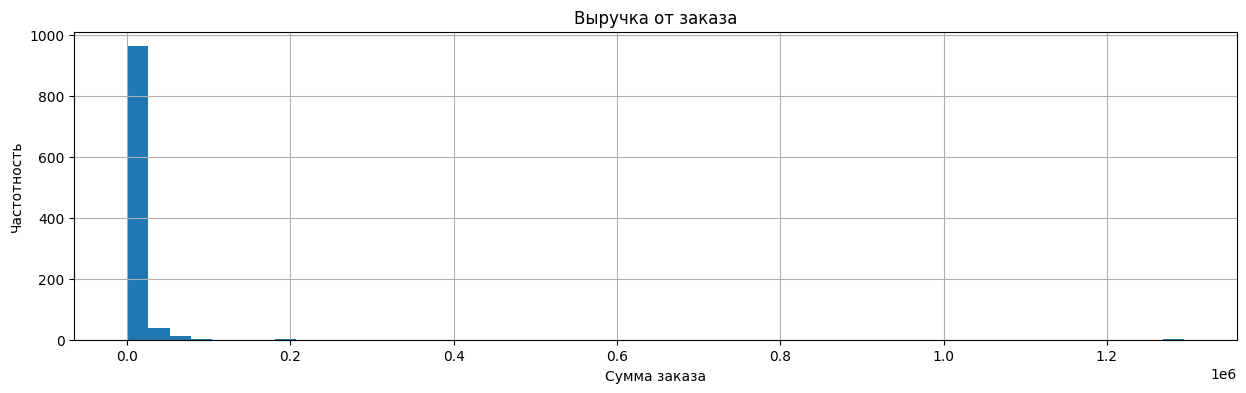

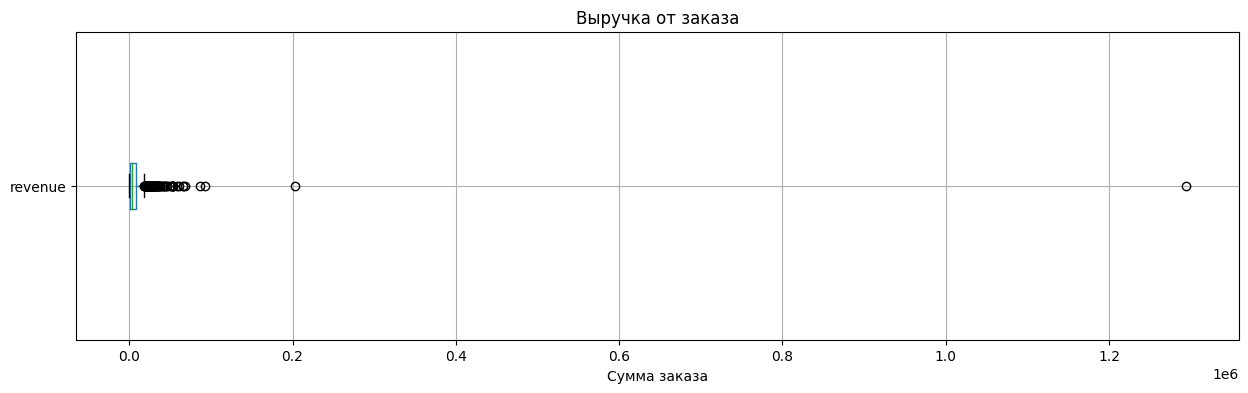

In [11]:
# выведем описание данных, гистограмму и диаграмму размаха
print(orders['revenue'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))
orders['revenue'].hist(bins=50, figsize=(15, 4))
plt.title('Выручка от заказа')
plt.xlabel('Сумма заказа')
plt.ylabel('Частотность')
plt.show()
orders.boxplot(column='revenue', vert=False, figsize=(15, 4))
plt.title('Выручка от заказа')
plt.xlabel('Сумма заказа')
plt.show()

99% процентов всех заказов укладываются в 54т.р. при медиане около 3т.р. То есть в основном заказы совершались на сравнительно небольшие суммы, однако среди них есть серьезные выбросы, в том числе превышающие 1 млн.р. Неизвестно, идет ли речь об ошибке или каких-то реальных дорогих заказах, в любом случае учтем этот момент при анализе А/В-теста.<br>
Рассмотрим данные о количестве заказов на посетителя. Здесь обойдемся гистограммой и выводом отдельных процентилей.

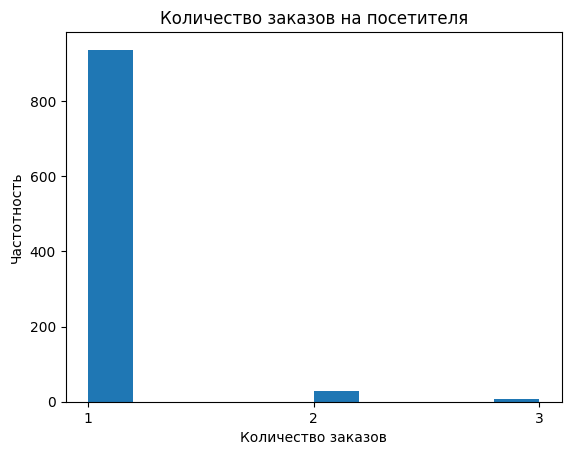

90-й, 95-й и 99-й процентили числа заказов: [1. 1. 2.]


In [12]:
# выведем гистограмму числа заказов на посетителя
plt.hist(orders.groupby('visitor_id').agg({'transaction_id':'count'}))
plt.xticks([1, 2, 3])
plt.title('Количество заказов на посетителя')
plt.xlabel('Количество заказов')
plt.ylabel('Частотность')
plt.show()
# выведем 90, 95 и 99 процентили
print(
    '90-й, 95-й и 99-й процентили числа заказов:', 
    np.percentile(orders.groupby('visitor_id').agg({'transaction_id':'count'}), [90, 95, 99])
)

95% посетителей совершили не более 1 заказа и 99% - не более 2. <br>
Осталось посмотреть количество посетителей в день. 

       visitors
count     31.00
mean    1214.58
std      226.87
min      773.00
25%     1062.00
50%     1259.00
75%     1411.00
90%     1463.00
95%     1484.00
99%     1508.00
max     1517.00


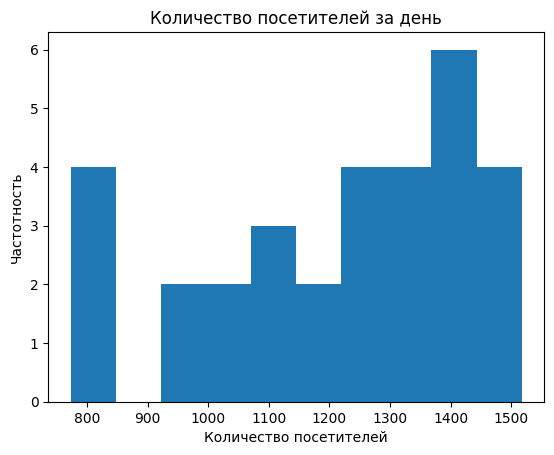

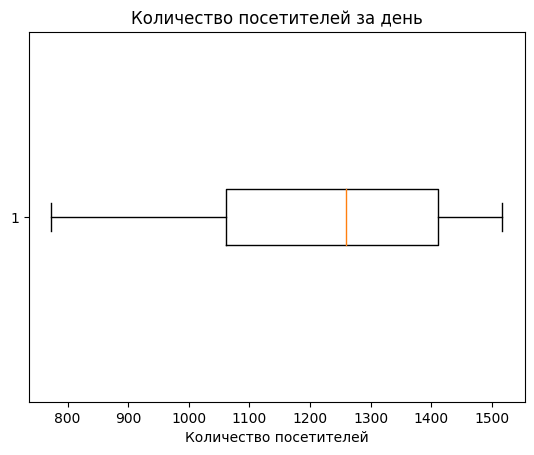

In [13]:
# выведем описание данных, гистограмму и диаграмму размаха, объединив обе группы
print(visitors.groupby('date').agg({'visitors':'sum'}).describe(percentiles=[.25, .5, .75, .9, .95, .99]))
plt.hist(visitors.groupby('date').agg({'visitors':'sum'}))
plt.title('Количество посетителей за день')
plt.xlabel('Количество посетителей')
plt.ylabel('Частотность')
plt.show()
plt.boxplot(visitors.groupby('date').agg({'visitors':'sum'}), vert=False)
plt.title('Количество посетителей за день')
plt.xlabel('Количество посетителей')
plt.show()

По количеству посетителей каких-то выбросов не наблюдаем, практически все значения укладываются в диапазон 800-1500.

Предварительная обработка данных завершена. Перейдем к гипотезам.

#### 3. <a id="prioritization">Приоритизация гипотез</a>

Приоритизируем гипотезы фреймворком ICE.

In [14]:
# добавим в датафрейм hypotheses столбец с оценкой гипотез методом ICE
hypotheses['ICE'] =  hypotheses['impact'] * hypotheses['confidence'] / hypotheses['efforts']
# выведем результат с сортировкой по убыванию
hypotheses[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Метод ICE отдает приоритет акции со скидками на день рождения. Можно предположить, что такая акция действительно будет пользоваться спросом, однако представляется, что она скорее будет эффективна для удержания уже существующих в базе клиентов и стимулирования повторных покупок. В силу растянутости во времени и точечного воздействия вряд ли от нее можно ожидать статистически значимого роста выручки. 

Учтем при приоритизации охват.

In [15]:
# добавим в датафрейм hypotheses столбец с оценкой гипотез методом RICE
hypotheses['RICE'] =  hypotheses['impact'] * hypotheses['confidence'] * hypotheses['reach'] / hypotheses['efforts']
# выведем результат с сортировкой по убыванию
hypotheses[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


Учет охвата изменил ситуацию. Предложение добавить форму подписки на основные страницы, чтобы собрать базу клиентов для email-рассылок, поднялось с 3-го на первое место в рейтинге приоритетности. То есть такой способ привлечения клиентов и, соответственно, увеличения выручки, предполагает максимальный охват и с учетом довольно хорошей оценки методом ICE представляется наиболее эффективным. Чего нельзя сказать об акции со скидками на день рождения, охват которой, судя по двум оценкам, фактически нулевой, то есть она не даст существенного прироста показателей.

#### 4. <a id="analysis">Анализ А/В-теста</a>

##### 4.1. <a id="one">Кумулятивная выручка по группам</a> <br>
Посчитаем кумулятивные данные о выручке и посетителях по дням.

In [16]:
# создадим массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получим агрегированные кумулятивные по дням данные о заказах 
orders_aggregated = (
    dates_groups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
           .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), 
           axis=1)
    .sort_values(by=['date','group'])
)

# получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_aggregated = (
    dates_groups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
           .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group'])
)

# объединим кумулятивные данные в одной таблице и присвоим ее столбцам понятные названия
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
# выведем первые строки таблицы для проверки
cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Построим график кумулятивной выручки по группам.

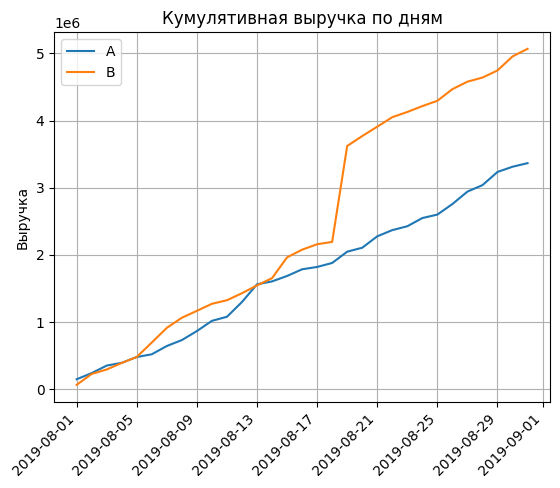

In [17]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# cтроим график выручки группы А
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')

# cтроим график выручки группы B
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

# оформляем график
plt.title('Кумулятивная выручка по дням')
plt.ylabel('Выручка')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.legend();

Судя по графику, группа В опережает по выручке группу А. В обеих группах показатель растет довольно плавно, однако в группе В наблюдается всплеск, который, видимо, объясняется наличием обнаруженных на этапе предобработки аномально дорогих заказов. Мы их учтем в дальнейшем анализе.

##### 4.2. <a id="two">Кумулятивный средний чек</a> <br>
Построим график кумулятивного среднего чека по группам.

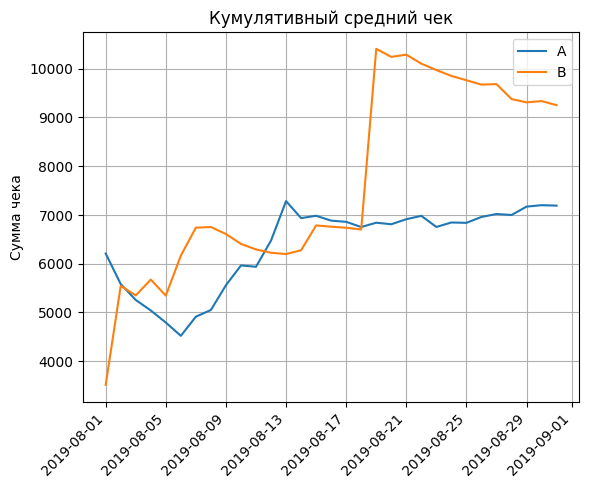

In [18]:
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.title('Кумулятивный средний чек')
plt.ylabel('Сумма чека')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.legend();

Для группы А средний чек можно считать установившимся. На средний чек группы В, видимо, повлияли выбросы в данных, он начал выравниваться только ближе к концу теста. На момент завершения наблюдений он существенно выше среднего чека группы А, однако пока затруднительно сказать, установится ли он на этом уровне или продолжит падать.

##### 4.3. <a id="three">Относительное изменение кумулятивного среднего чека группы B к группе A</a> <br>
Построим график для оценки относительного изменения кумулятивного среднего чека группы B к группе A.

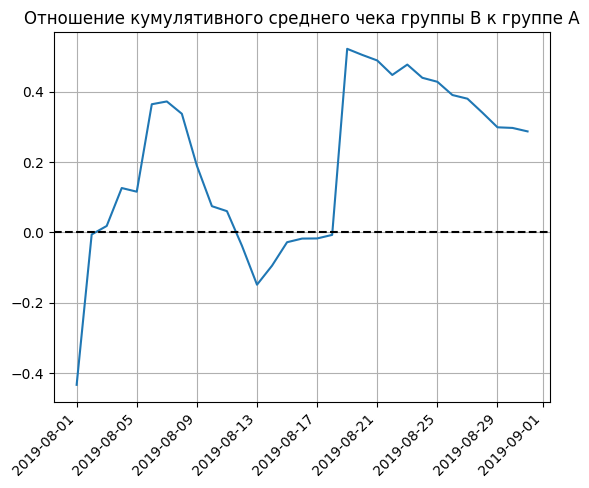

In [19]:
# соберем данные в одном датафрейме
merged_cumulative_revenue = (
    cumulative_revenue_A
    .merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

# поcтроим отношение средних чеков
plt.plot(
    merged_cumulative_revenue['date'], 
    (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/
    (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1
)

# добавим ось X
plt.axhline(y=0, color='black', linestyle='--')

# оформляем график
plt.title('Отношение кумулятивного среднего чека группы В к группе А')
plt.xticks(rotation=45, ha='right')
plt.grid();

Колебания на графике снова указывают на выбросы в данных. Сейчас по нему сложно оценить эффективность эксперимента.

##### 4.4. <a id="four">Кумулятивная конверсия</a> <br>
Построим график кумулятивного среднего количества заказов на посетителя по группам.

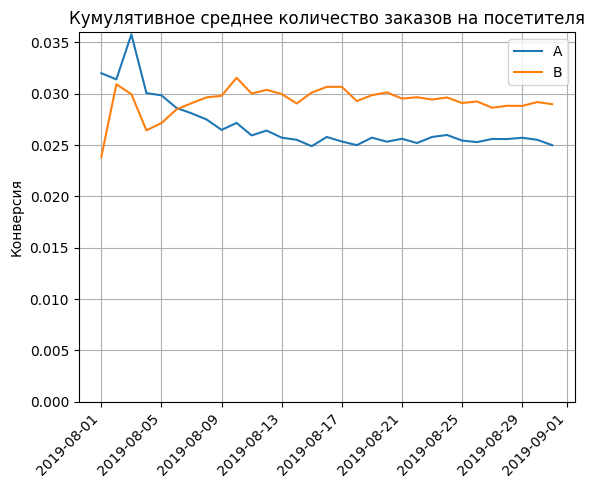

In [20]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')

# задаем масштаб осей
plt.axis([None, None, 0, 0.036]) 

# оформляем график
plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.ylabel('Конверсия')
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.legend();

Можно сказать, что кумулятивная конверсия для обеих групп более-менее зафиксировалась и составляет около 2,5% для группы А и немногим менее 3% для группы В.

##### 4.5. <a id="five">Относительное изменение кумулятивной конверсии группы B к группе A</a> <br>
Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

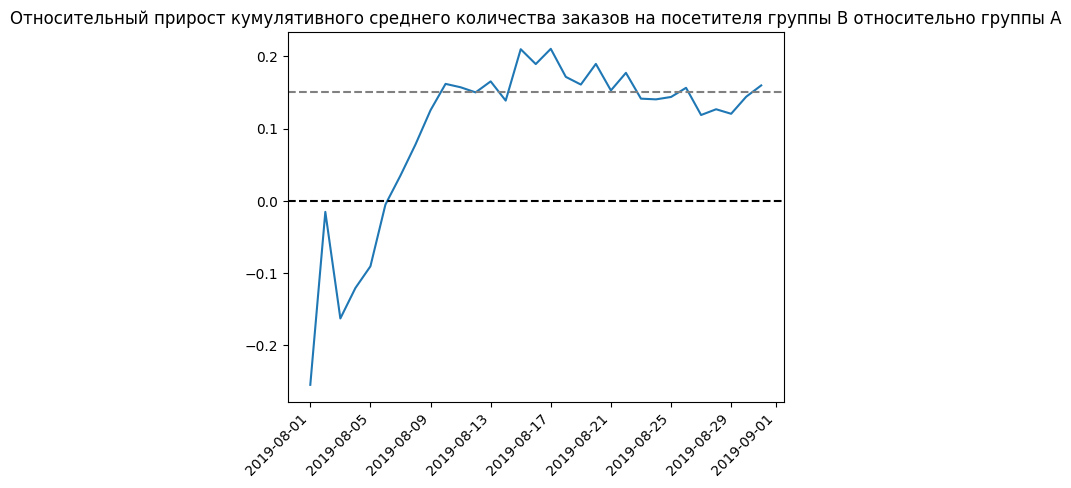

In [21]:
# обединим данные по кумулятивной конверсии
merged_cumulative_conversions = (
    cumulative_data_A[['date','conversion']]
    .merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

# построим график
plt.plot(
    merged_cumulative_conversions['date'], 
    merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1
)

# добавим оси Х
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')

# оформляем график
plt.title('Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A')
plt.xticks(rotation=45, ha='right');

В первую неделю теста группа В отставала от группы А, но затем вырвалась вперед и сохраняется примерно на одном уровне на протяжении трех недель. Это позволяет заключить, что кумулятивная конверсия у группы В стабильно выше.

##### 4.6. <a id="six">Количество заказов по посетителям</a> <br>
Построим точечный график количества заказов по посетителям.

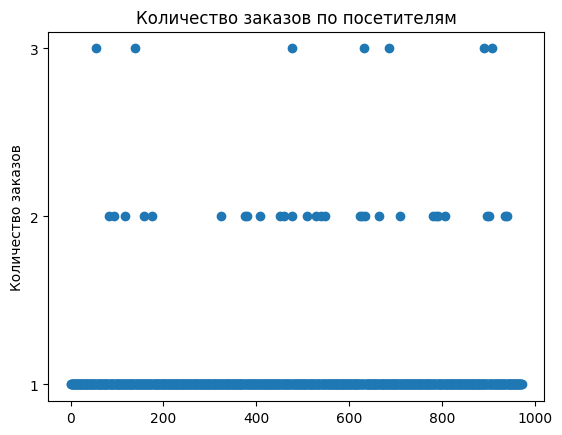

In [22]:
# посчитаем количество заказов на посетителя
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
# переименуем столбцы
orders_by_users.columns = ['visitor_id', 'orders']
# найдем диапазон значений
x_values = pd.Series(range(0,len(orders_by_users)))
# построим график
plt.scatter(x_values, orders_by_users['orders'])
plt.yticks([1, 2, 3])
plt.title('Количество заказов по посетителям')
plt.ylabel('Количество заказов');

Абсолютное большинство совершило за месяц наблюдения всего 1 заказ. Лишь единицы сделали по 3 заказа.

##### 4.7. <a id="seven">95-й и 99-й процентили количества заказов на пользователя</a> <br>
Чтобы найти границу для определения аномальных пользователей, вычислим 95-й и 99-й процентили количества заказов на пользователя.

In [23]:
print(
    '95-й и 99-й процентили числа заказов:', 
    np.percentile(orders_by_users['orders'], [95, 99])
)

95-й и 99-й процентили числа заказов: [1. 2.]


Всего 1% процент пользователей оформил более 2 заказов, т.е. пользователей с 3 заказами можно будет отсеять.

##### 4.8. <a id="eight">Стоимость заказов</a> <br>
Построим точечный график стоимостей заказов.

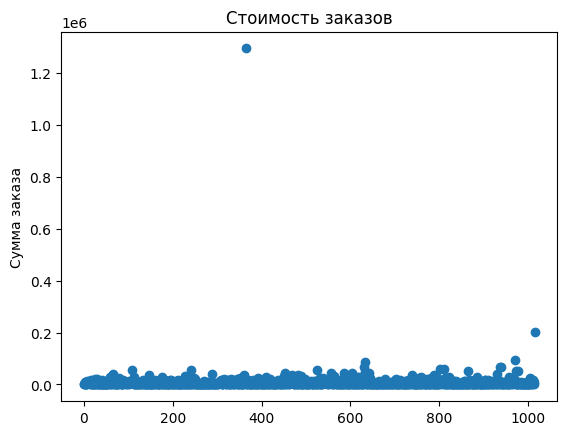

In [24]:
# найдем диапазон значений
x_values = pd.Series(range(0,len(orders['revenue'])))
# построим график
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.ylabel('Сумма заказа');

Стоимость заказа почти никогда не превышает 100 000 р. Скорее всего, граница выбросов будет даже ниже.

Построим график для заказов, сумма которых не превышает 100 000 р.

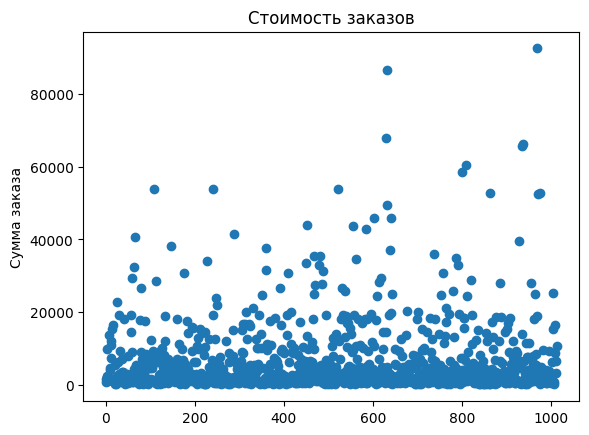

In [25]:
# найдем диапазон значений
x_values = pd.Series(range(0,len(orders[orders['revenue'] <= 100000]['revenue'])))
# построим график
plt.scatter(x_values, orders[orders['revenue'] <= 100000]['revenue'])
plt.title('Стоимость заказов')
plt.ylabel('Сумма заказа');

Основная доля заказов совершена на сумму не более 20 000 р., а заказы примерно от 50 000 р. и выше совсем редки. Определим точнее границу выбросов с помощью процентилей.

##### 4.9. <a id="nine">95-й и 99-й процентили стоимости заказов</a> <br>
Чтобы найти границу для определения аномальных заказов, вычислим 95-й и 99-й процентили стоимости заказов.

In [26]:
print(
    '95-й и 99-й процентили стоимости заказов:', 
    np.percentile(orders['revenue'], [95, 99])
)

95-й и 99-й процентили стоимости заказов: [26785. 53904.]


Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Установим верхнюю границу на уровне 99-го процентиля, так как датасет уже сильно уменьшился после удаления пересекающихся пользователей. При удалении аномальных пользователей экспериментировали с разными процентилями от 95-го до 99-го: абсолютные значения колебались, но значимого влияния на результаты не оказали.

##### 4.10. <a id="ten">Cтатистическая значимость различий в конверсии между группами по «сырым» данным</a> <br>
Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сформулируем гипотезы: 
- нулевая: различий в среднем количестве заказов между группами нет;
- альтернативная: различия в среднем между группами есть.<br>

Гипотезы здесь и далее будем проверять методом Манна-Уитни (в основном из-за ненормальности распределений) и зададим уровень статистической значимости 5%.</div>

In [27]:
# подготовка данных
# найдем количество посетителей в обеих группах по дням и посчитаем их кумулятивный прирост
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_A_cumulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cumulative.columns = ['date', 'visitors_cumulative_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cumulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cumulative.columns = ['date', 'visitors_cumulative_B']

# посчитаем ежедневную и кумулятивную выручку в каждой группе
orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_A_cumulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_A_cumulative.columns = [
    'date',
    'orders_cumulative_A',
    'revenue_cumulative_A',
]

orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cumulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_B_cumulative.columns = [
    'date',
    'orders_cumulative_B',
    'revenue_cumulative_B',
]

# объединим полученные датафреймы
data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cumulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cumulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cumulative, left_on='date', right_on='date', how='left')
)
# выведем первые строки для проверки
data.head(5)

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cumulative_A,revenue_cumulative_A,orders_cumulative_B,revenue_cumulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cumulative_A,visitors_cumulative_B
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


In [28]:
# найдем количество заказов на посетителя в каждой группе
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor_id', 'orders']

sample_A = pd.concat(
    [
        orders_by_users_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B = pd.concat(
    [
        orders_by_users_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
# посчитаем стат.значимость различий в среднем количестве заказов на посетителя между группами 
# и относительный прирост среднего числа заказов группы B
print('P-value:', "{0:.3f}".format(st.mannwhitneyu(sample_A, sample_B)[1]))

print('Oтносительный прирост среднего числа заказов группы B:', "{0:.3f}".format(sample_B.mean() / sample_A.mean() - 1))

P-value: 0.011
Oтносительный прирост среднего числа заказов группы B: 0.160


Относительный прирост среднего числа заказов для группы В составляет 16%. При этом p-value в данном случае меньше 0.05. Соответственно, различие в среднем числе заказов между группами по «сырым» данным является статистически значимым. Можно полагать, что в группе В конверсия выше, то есть заказов на посетителя больше.

##### 4.11. <a id="eleven">Cтатистическая значимость различий в среднем чеке по «сырым» данным</a> <br>
Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным. <br>
Нулевая гипотеза: различий в среднем чеке между группами нет. <br>
Альтернативная гипотеза: различия в среднем чеке между группами есть.

In [29]:
# рассчитаем статистическую значимость различий в среднем чеке
print('P-value:', 
      '{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
# найдем относительные различия в среднем чеке между группами
print('Oтносительные различия в среднем чеке между группами:', 
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue']
                       .mean()/orders[orders['group']=='A']['revenue']
                       .mean()-1))

P-value: 0.829
Oтносительные различия в среднем чеке между группами: 0.287


P-value значительно больше 0.05, что указывает на отсутствие различий в среднем чеке между группами. При этом относительная разница составляет почти 29% в пользу группы В. Вероятно, на средний чек группы В повлияли аномально дорогие заказы. Посмотрим, что поменяется после удаления выбросов.

##### 4.12. <a id="twelve">Cтатистическая значимость различий в конверсии между группами по «очищенным» данным</a> <br>
Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сначала уберем из данных выбросы.

In [30]:
# найдем посетителей с количеством заказов > 2
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > np.percentile(orders_by_users['orders'], 99)]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > np.percentile(orders_by_users['orders'], 99)]['visitor_id'],
    ],
    axis=0,
)
# найдем посетителей с дорогими заказами
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']
# объединим аномальных посетителей в один датафрейм
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
# выведем первые строки и число аномальных посетителей
print(abnormal_users.head(5))
abnormal_users.shape[0]

937    148427295
33     249864742
58     611059232
811    887908475
632    888512513
Name: visitor_id, dtype: int64


16

16 посетителей с аномальными значениями. Узнаем, какое влияние они оказали на результаты теста.

In [31]:
# уберем из данных аномальных посетителей
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
# применим статистический критерий Манна-Уитни к полученным выборкам
print('P-value:', '{0:.3f}'.format(st.mannwhitneyu(sample_A_filtered, sample_B_filtered)[1]))
print('Oтносительный прирост среднего числа заказов группы B:', 
      '{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

P-value: 0.007
Oтносительный прирост среднего числа заказов группы B: 0.189


P-value стал еще меньше, а относительная разница в количестве заказов еще подросла в пользу группы В. То есть в данном случае аномалии хоть и повлияли на результаты теста, но не изменили сути: разница в количестве заказов на посетителя осталась статистически значимой, а посетители из группы В совершают в среднем больше заказов.

##### 4.13. <a id="thirteen">Cтатистическая значимость различий в среднем чеке по «очищенным» данным</a> <br>
Посчитаем статистическую значимость различий в среднем чеке между группами по «очищенным» данным.

In [32]:
print(
    'P-value:',
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Oтносительные различия в среднем чеке между группами:',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.788
Oтносительные различия в среднем чеке между группами: -0.032


В "очищенных" данных статистически значимых различий по средним чекам по-прежнему нет. А вот относительная разница между средними чеками сведена практически к нулю.<br>

На основании полученных результатов можно заключить, что различий в среднем чеке между группами нет, но в группе В конверсия, т.е. относительное количество заказов, выше. Если цель эксперимента состояла в увеличении выручки, то его можно признать успешным: даже без учета дорогих заказов группа В принесла компании больше денег за счет роста числа заказов на посетителя.

#### 5. <a id="summary">Выводы</a>

Мы приоритизировали гипотезы для увеличения выручки интернет-магазина и проанализировали результаты А/В-теста. <br>
В ходе приоритизации было подтверждено, что маркетинговые меры, предполагающие больший охват аудитории, дадут более заметный эффект, чем точечные меры, даже если остальные параметры последних выше. <br>
Анализ результатов А/В-теста показал, что даже при одинаковом среднем чеке увеличение выручки будет обеспечиваться за счет роста конверсии. <br>
Таким образом, тест можно остановить и зафиксировать победу за группой В.